In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random
from google.colab import drive
from google.colab import files
import shutil

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from numpy.random import seed
import pickle
seed(1)
tf.random.set_seed(1)

In [ ]:
# mount drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root_path = "/content/drive/Shareddrives/[Deep Learning Project]"
dataset_dir = os.path.join(root_path, "Dataset")
balanced_train_dir = os.path.join(dataset_dir, 'balanced_train') # We're using the balanced dataset
test_dir = os.path.join(dataset_dir, 'test')

In [ ]:
#Set the parameter used to load the dataset
BATCH_SIZE = 64
IMAGE_HEIGHT = 180
IMAGE_WIDTH = 180

#Creation of the training, validation and test set

We exploit the directory hierarchy of our dataset to infer the classes from the
name of the directories, more details are present in the report about the choices taken.

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    balanced_train_dir,
    labels='inferred', 
    label_mode='categorical',
    class_names=None, 
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    subset="training",
    shuffle=True,
    seed=1024)

validation_dataset = image_dataset_from_directory(
    balanced_train_dir,
    labels='inferred', 
    label_mode='categorical',
    class_names=None, 
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    subset="validation",
    shuffle=True,
    seed=1024)

test_dataset = image_dataset_from_directory(
    test_dir,
    labels='inferred', 
    label_mode='categorical',
    class_names=None, 
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

Found 8100 files belonging to 18 classes.
Using 7290 files for training.
Found 8100 files belonging to 18 classes.
Using 810 files for validation.
Found 1112 files belonging to 18 classes.


In [ ]:
dir_name = os.path.join(root_path, "Models")
if not os.path.exists(dir_name):
  os.makedirs(dir_name)

Let's import the pre-trained model:

In [ ]:
from tensorflow.keras.applications import VGG16

conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [ ]:
import numpy as np

print('This is the number of trainable weights '
      'before freezing the conv base:', sum(np.prod(x.shape) for x in conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 14714688


# Feature extraction

Let's freeze all the layers in the convolution base:

In [ ]:
conv_base.trainable = False

In [ ]:
print('This is the number of trainable weights '
      'after freezing the conv base:', sum(np.prod(x.shape) for x in conv_base.trainable_weights))

# Make sure you have frozen the correct layers
for i, layer in enumerate(conv_base.layers):
    print(i, layer.name, layer.trainable)

This is the number of trainable weights after freezing the conv base: 0
0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False


In [ ]:
from tensorflow.keras import layers

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
])

Now we define the classifier that we will add on top of the convolutional base:

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
outputs = layers.Dense(18, activation="softmax")(x)

optimizer = keras.optimizers.Adam(learning_rate=1e-3)

model = keras.Model(inputs, outputs)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=["accuracy"])


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 180, 180, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 180, 180, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                             

**Let's add Keras callbacks:**
*   Early stopping
*   ModelCheckpoint
*   ReduceLROnPlateau

In [ ]:
callbacks_list = [
    keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=12),

    keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(dir_name, 'VGG16_feature_extraction_no_dropout.h5'),
    monitor='val_loss',
    save_best_only=True,
    ),

    keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    )
]

Train the network:

In [ ]:
history = model.fit(train_dataset,
                    epochs=100,
                    callbacks=callbacks_list,
                    validation_data=validation_dataset
                    )

Epoch 1/100
114/114 [==============================] - 2547s 21s/step - loss: 3.5164 - accuracy: 0.3652 - val_loss: 1.7331 - val_accuracy: 0.5136 - lr: 0.0010
Epoch 2/100
114/114 [==============================] - 39s 327ms/step - loss: 1.4102 - accuracy: 0.5953 - val_loss: 1.3784 - val_accuracy: 0.6284 - lr: 0.0010
Epoch 3/100
114/114 [==============================] - 38s 322ms/step - loss: 1.1010 - accuracy: 0.6807 - val_loss: 1.2197 - val_accuracy: 0.6716 - lr: 0.0010
Epoch 4/100
114/114 [==============================] - 39s 324ms/step - loss: 0.8926 - accuracy: 0.7320 - val_loss: 1.0621 - val_accuracy: 0.7148 - lr: 0.0010
Epoch 5/100
114/114 [==============================] - 37s 307ms/step - loss: 0.7691 - accuracy: 0.7719 - val_loss: 1.1190 - val_accuracy: 0.7395 - lr: 0.0010
Epoch 6/100
114/114 [==============================] - 38s 314ms/step - loss: 0.6210 - accuracy: 0.8159 - val_loss: 0.9693 - val_accuracy: 0.7543 - lr: 0.0010
Epoch 7/100
114/114 [=========================

Shows some plots to better evaluate the model:

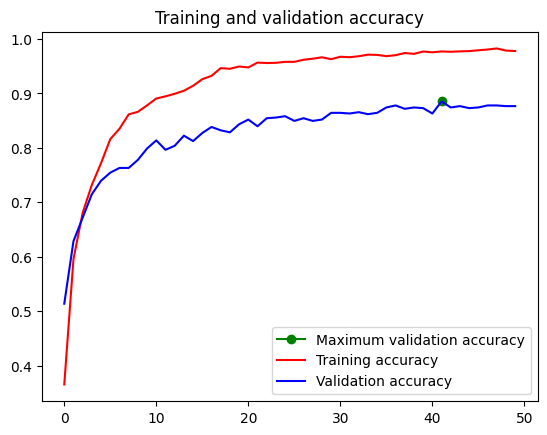

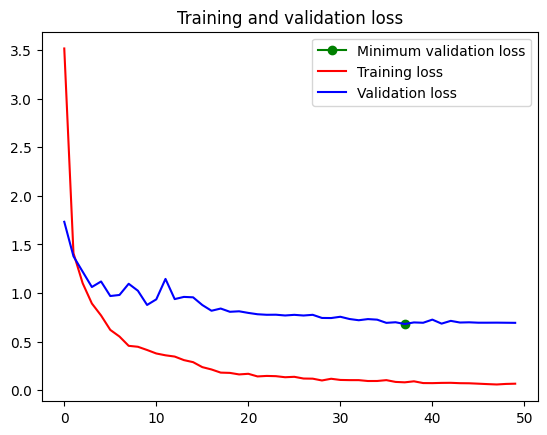

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

i = np.argmax(val_acc)
x_min = epochs[i]
y_min = val_acc[i]
plt.plot(x_min, y_min,'g',marker='o', label="Maximum validation accuracy")

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

i = np.argmin(val_loss)
x_min = epochs[i]
y_min = val_loss[i]
plt.plot(x_min, y_min,'g',marker='o', label="Minimum validation loss")

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Fine tuning:

We will **fine-tune the last 3 convolutional layers**, which means that all layers up until `block4_pool` should be frozen, and the layers 
`block5_conv1`, `block5_conv2` and `block5_conv3` should be trainable.

In [ ]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [ ]:
# Make sure you have frozen the correct layers
for i, layer in enumerate(conv_base.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=1e-5)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 180, 180, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 180, 180, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                             

Let's add the same Keras callbacks as before:

In [ ]:
callbacks_list = [
    keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15),

    keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(dir_name, 'VGG16_fine_tuning.h5'),
    monitor='val_loss',
    save_best_only=True,
    ),

    keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    )
]



history = model.fit(train_dataset,
                    epochs=100,
                    callbacks=callbacks_list,
                    validation_data=validation_dataset
                    )

Epoch 1/100
114/114 [==============================] - 48s 366ms/step - loss: 0.0738 - accuracy: 0.9761 - val_loss: 0.7779 - val_accuracy: 0.8716 - lr: 1.0000e-05
Epoch 2/100
114/114 [==============================] - 39s 324ms/step - loss: 0.0719 - accuracy: 0.9770 - val_loss: 0.8378 - val_accuracy: 0.8642 - lr: 1.0000e-05
Epoch 3/100
114/114 [==============================] - 39s 328ms/step - loss: 0.0812 - accuracy: 0.9734 - val_loss: 0.7499 - val_accuracy: 0.8790 - lr: 1.0000e-05
Epoch 4/100
114/114 [==============================] - 38s 316ms/step - loss: 0.0689 - accuracy: 0.9802 - val_loss: 0.7708 - val_accuracy: 0.8840 - lr: 1.0000e-05
Epoch 5/100
114/114 [==============================] - 37s 307ms/step - loss: 0.0612 - accuracy: 0.9808 - val_loss: 0.7583 - val_accuracy: 0.8716 - lr: 1.0000e-05
Epoch 6/100
114/114 [==============================] - 39s 328ms/step - loss: 0.0534 - accuracy: 0.9813 - val_loss: 0.7260 - val_accuracy: 0.8852 - lr: 1.0000e-05
Epoch 7/100
114/114 [=

Shows some plots to better evaluate the model:


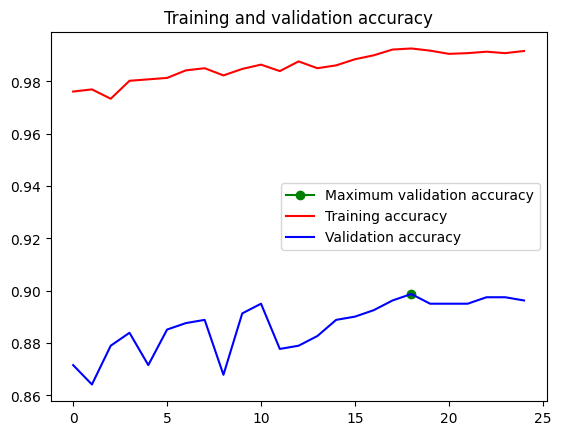

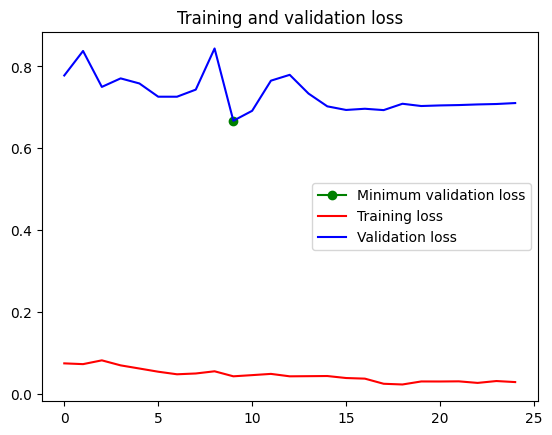

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

i = np.argmax(val_acc)
x_min = epochs[i]
y_min = val_acc[i]
plt.plot(x_min, y_min,'g',marker='o', label="Maximum validation accuracy")

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

i = np.argmin(val_loss)
x_min = epochs[i]
y_min = val_loss[i]
plt.plot(x_min, y_min,'g',marker='o', label="Minimum validation loss")

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
#Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_dataset)

#Save the rusults in the history dictionary
history.history["test_loss"] = test_loss
history.history["test_accuracy"] = test_acc

print('test_acc:', test_acc)
print('test_loss:', test_loss)

18/18 [==============================] - 475s 14s/step - loss: 3.4191 - accuracy: 0.6754
test_acc: 0.6753597259521484
test_loss: 3.4190728664398193
